## CS310 Natural Language Processing
## Assignment 3. Recurrent Neural Networks for Language Modeling 

**Total points**: 

In this assignment, you will train a vanilla RNN-based language model on the Harry Potter text data. 

### 0. Import Necessary Libraries

In [3]:
import sys

print(sys.executable)  # 输出当前内核的 Python 解释器路径

/mnt/lijl/anaconda3/envs/nnUnet/bin/python


In [4]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
# nltk.download('punkt_tab')  # 只需运行一次
from collections import Counter
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
# load in TXT
HarryPotterURL = 'Harry_Potter_all_books_preprocessed.txt'
with open(HarryPotterURL, 'r', encoding='utf-8') as file:
    text = file.read()
print(text[:500])

THE BOY WHO LIVED Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you very much .They were the last people youd expect to be involved in anything strange or mysterious because they just didnt hold with such nonsense .Mr Dursley was the director of a firm called Grunnings which made drills .He was a big beefy man with hardly any neck although he did have a very large mustache .Mrs Dursley was thin and blonde and had nearly twice the usual amo


In [6]:
## 分词
tokens = word_tokenize(text)
print(len(tokens))
# 词频
counter = Counter(tokens)
# 构建 word2id 词表，并加入特殊 token
word2id = {'<pad>': 0, '<unk>': 1}
for i, word in enumerate(counter.keys(), start=2):
    word2id[word] = i
# 构建 id2word 词表
id2word = {idx: word for word, idx in word2id.items()}
# 转换为 ID 序列
token_ids = [word2id.get(word, word2id['<unk>']) for word in tokens]
# 测试输出
print("Word2id: Total vocabulary = " + str(len(word2id)))
print(word2id["THE"], word2id["Harry"])
print(id2word[0], id2word[1], id2word[2])

1105952
Word2id: Total vocabulary = 30248
2 429
<pad> <unk> THE


In [7]:
class LanguageModelingDataset(torch.utils.data.Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.block_size]
        y = self.data[idx + 1: idx + self.block_size + 1]
        return x, y


# 转换成 LongTensor
data_tensor = torch.tensor(token_ids, dtype=torch.long)

# 划分 train set和 test set
train_ratio = 0.9
train_len = int(train_ratio * len(data_tensor))
train_data = data_tensor[:train_len]
test_data = data_tensor[train_len:]
print(train_data.shape)
print(test_data.shape)

# 构建tensor
block_size = 32
batch_size = 32
train_dataset = LanguageModelingDataset(train_data, block_size)
test_dataset = LanguageModelingDataset(test_data, block_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

torch.Size([995356])
torch.Size([110596])


### 1. Build the Model

In [8]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=50, hidden_dim=100, num_layers=1, bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

        output_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(output_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        logits = self.fc(out)
        log_probs = torch.log_softmax(logits, dim=-1)
        return log_probs, hidden


### 2. Train and Evaluate

In [9]:
def train_model(model, dataloader, optimizer, criterion, scheduler=None, epochs=5, device="cpu"):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for X, Y in tqdm(dataloader):
            # print(X.shape, Y.shape)
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            outputs, _ = model(X)
            loss = criterion(outputs.view(-1, outputs.size(-1)), Y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        if scheduler:
            scheduler.step()
        print(f"Epoch {epoch + 1} | Avg Loss: {avg_loss:.4f}", end="")
        if scheduler:
            print(f" | LR: {scheduler.get_last_lr()[0]:.6f}")
        else:
            print()
    return loss_history

In [10]:
def evaluate_model(model, dataloader, criterion, device="cpu"):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            outputs, _ = model(X)
            loss = criterion(outputs.view(-1, outputs.size(-1)), Y.view(-1))
            total_loss += loss.item()
    ppl = math.exp(total_loss / len(dataloader))
    print(f"Perplexity: {ppl:.2f}")
    return ppl


In [16]:
def clean_prefix(prefix, word2id):
    # 清理 prefix 中的 <unk> 标签，直接删除它们
    tokens = prefix.lower().split()
    cleaned_tokens = [token for token in tokens if word2id.get(token) is not None]  # 仅保留词汇表中存在的单词
    return ' '.join(cleaned_tokens)

def generate_greedy(model, word2id, id2word, prefix, max_len=20, device="cpu"):
    model.eval()

    # 清理 prefix，去除 <unk> 标签
    cleaned_prefix = clean_prefix(prefix, word2id)
    tokens = cleaned_prefix.lower().split()
    
    # 生成 initial input_ids (确保每个词都在词汇表中)
    input_ids = [word2id.get(w, word2id["<unk>"]) for w in tokens]
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

    hidden = None
    generated_tokens = []  # 用于保存生成的 tokens（不重复）

    with torch.no_grad():
        for _ in range(max_len):
            # 当前生成的 token 是基于 input_tensor 的最新内容进行生成的
            output, hidden = model(input_tensor, hidden)
            last_token_logits = output[:, -1, :]  # 取最后一个位置的输出
            next_token = torch.argmax(last_token_logits, dim=-1).item()

            # 将新生成的 token 加入 generated_tokens
            generated_tokens.append(next_token)
            
            # 将新生成的 token 拼接到 input_tensor 中用于下一步生成
            input_tensor = torch.cat([input_tensor, torch.tensor([[next_token]], device=device)], dim=1)

    # 拼接生成的结果并返回
    result = ' '.join([id2word.get(idx, "<unk>") for idx in generated_tokens])
    return result


In [12]:
# 初始化模型
vocab_size = len(word2id)
rnn_model = RNNLanguageModel(vocab_size=vocab_size, embed_dim=50, hidden_dim=100, num_layers=1, bidirectional=False)

# 准备训练工具
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = rnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 启动训练
print("Training Vanilla RNN...")
rnn_loss_history = train_model(rnn_model, train_loader, optimizer, criterion, scheduler=scheduler, epochs=10,
                               device=device)

# 评估模型（Perplexity）
print("Evaluating RNN...")
rnn_ppl = evaluate_model(rnn_model, test_loader, criterion, device=device)


Training Vanilla RNN...


100%|██████████| 31104/31104 [04:25<00:00, 117.20it/s]


Epoch 1 | Avg Loss: 4.4778 | LR: 0.003000


100%|██████████| 31104/31104 [04:25<00:00, 116.96it/s]


Epoch 2 | Avg Loss: 3.9924 | LR: 0.003000


100%|██████████| 31104/31104 [04:23<00:00, 117.87it/s]


Epoch 3 | Avg Loss: 3.9085 | LR: 0.000300


100%|██████████| 31104/31104 [04:24<00:00, 117.79it/s]


Epoch 4 | Avg Loss: 3.6620 | LR: 0.000300


100%|██████████| 31104/31104 [04:24<00:00, 117.74it/s]


Epoch 5 | Avg Loss: 3.6215 | LR: 0.000300


100%|██████████| 31104/31104 [04:25<00:00, 117.30it/s]


Epoch 6 | Avg Loss: 3.6070 | LR: 0.000030


100%|██████████| 31104/31104 [04:23<00:00, 118.17it/s]


Epoch 7 | Avg Loss: 3.5803 | LR: 0.000030


100%|██████████| 31104/31104 [04:24<00:00, 117.44it/s]


Epoch 8 | Avg Loss: 3.5760 | LR: 0.000030


100%|██████████| 31104/31104 [04:22<00:00, 118.31it/s]


Epoch 9 | Avg Loss: 3.5742 | LR: 0.000003


100%|██████████| 31104/31104 [04:24<00:00, 117.53it/s]


Epoch 10 | Avg Loss: 3.5707 | LR: 0.000003
Evaluating RNN...
Perplexity: 1514.52


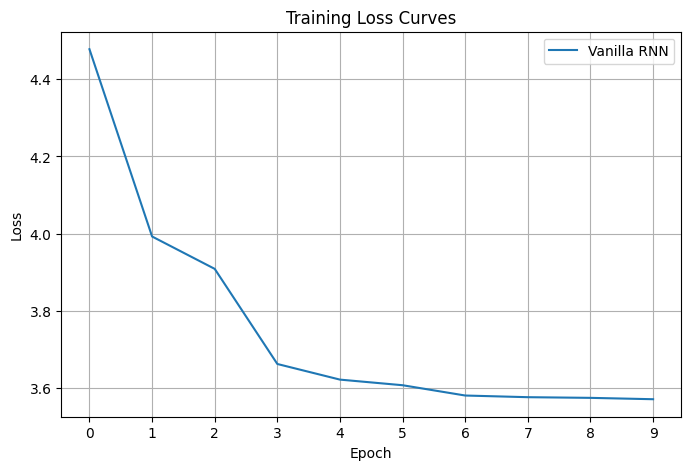

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(rnn_loss_history, label="Vanilla RNN")
plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(rnn_loss_history)))

plt.legend()
plt.grid(True)
plt.show()


In [14]:
prefix = "Harry looked at"
print(f"\nGenerated sentences from prefix: '{prefix}'\n")

for i in range(5):
    rnn_output = generate_greedy(rnn_model, word2id, id2word, prefix, max_len=20, device=device)

    print(f"Pair {i + 1}:")
    print("  RNN : ", rnn_output)


Generated sentences from prefix: 'Harry looked at'

Pair 1:
  RNN :  <unk> looked at each other and the Sorting Hat was streaking up the pitch hovering in the lefthand corner of the drive toward
Pair 2:
  RNN :  <unk> looked at each other and the Sorting Hat was streaking up the pitch hovering in the lefthand corner of the drive toward
Pair 3:
  RNN :  <unk> looked at each other and the Sorting Hat was streaking up the pitch hovering in the lefthand corner of the drive toward
Pair 4:
  RNN :  <unk> looked at each other and the Sorting Hat was streaking up the pitch hovering in the lefthand corner of the drive toward
Pair 5:
  RNN :  <unk> looked at each other and the Sorting Hat was streaking up the pitch hovering in the lefthand corner of the drive toward


In [18]:
prefixes = [
    "Harry looked at",
    "Harry looked over",
    "Hermione said that",
    "Ron said",
    "The wand flied",
    "Dumbledore rushed out the room angrily"
]

for prefix in prefixes:
    print(f"{prefix} {generate_greedy(rnn_model, word2id, id2word, prefix, max_len=50, device=device)}")

Harry looked at him and departed to the ground and throwing the cloak over his head and his eyes were growing boring tie to his feet and turned to the jeans door and a palomino body for the first time he had been in the castle to be educated .she said Harry and
Harry looked over the tip of his wand .Instantly Harry pelting his wand at the Inferius that had been a small vacant hole and headed off to the castle to the Department of Mysteries and the Ministry is currently publishing guides to elementary home for a few days of the same time in
Hermione said that he was not going to be able to get out of the castle ? said Harry angrily .I dont know what youre doing ? Harry asked Hermione .I mean I was going to be able to see Gringotts of the Order of the Phoenix ? said Harry angrily .I dont
Ron said Harry .Instantly Harry had not been in the wrong place at the end of the lesson .Overhead and his eyes were fixed upon the ground and the golden thread connecting the floor and threw it open and